# Off-Policy Evaluation using non-stationary bandit data

In [3]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
from pandas import DataFrame
from sklearn.linear_model import LogisticRegression
from obp.dataset import (
    SyntheticBanditDataset,
    logistic_reward_function,
    linear_behavior_policy
)

from obp.ope import (
    OffPolicyEvaluation,
    RegressionModel,
    InverseProbabilityWeighting as IPS,
    DoublyRobust as DR,
    DirectMethod as DM
)

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def gen_eps_greedy(
    expected_reward: np.ndarray,
    is_optimal: bool = True,
    eps: float = 0.1,
) -> np.ndarray:
    "Generate an evaluation policy via the epsilon-greedy rule."
    base_pol = np.zeros_like(expected_reward)
    if is_optimal:
        a = np.argmax(expected_reward, axis=1)
    else:
        a = np.argmin(expected_reward, axis=1)
    base_pol[
        np.arange(expected_reward.shape[0]),
        a,
    ] = 1
    pol = (1.0 - eps) * base_pol
    pol += eps / expected_reward.shape[1]

    return pol[:, :, np.newaxis]

In [5]:
# settings 1
n_sim=10
val_sizes = [800, 1600, 3200, 6400, 12800, 25600]
test_size=200000
n_actions=20
dim_context=10

In [6]:
# experiment-1 varying data size

dataset = SyntheticBanditDataset(
    n_actions=n_actions,
    dim_context=dim_context,
    reward_function=logistic_reward_function,
    behavior_policy_function=linear_behavior_policy,
)
# calculate ground truth policy value
test_data = dataset.obtain_batch_bandit_feedback(n_rounds=test_size)
test_action_dist =  gen_eps_greedy(expected_reward=test_data["expected_reward"])
policy_value = dataset.calc_ground_truth_policy_value(
    expected_reward=test_data["expected_reward"],
    action_dist=test_action_dist
)

result_df_list = []
for val_size in tqdm(val_sizes):
    
    result_list = []
    for _ in range(n_sim):
        val_data = dataset.obtain_batch_bandit_feedback(n_rounds=val_size)
        # pi_new
        val_action_dist = gen_eps_greedy(expected_reward=val_data["expected_reward"])

        q_hat_model = RegressionModel(
            n_actions=dataset.n_actions,
            base_model=LogisticRegression(max_iter=1000)
        )

        estimated_rewards = q_hat_model.fit_predict(
            context=val_data["context"],
            action=val_data["action"],
            reward=val_data["reward"]
        )

        ope = OffPolicyEvaluation(
            bandit_feedback=val_data,
            ope_estimators=[IPS(estimator_name="IPS"), DR(estimator_name="DR"), DM(estimator_name="DM")]
        )
        estimated_policy_values = ope.estimate_policy_values(
            action_dist=val_action_dist,
            estimated_rewards_by_reg_model=estimated_rewards
        )

        result_list.append(estimated_policy_values)
    
    result_df = (
        DataFrame(DataFrame(result_list).stack())
        .reset_index(1)
        .rename(columns={"level_1": "estimator", 0: "value"})
    )
    result_df["n_val_data"] = val_size
    result_df["se"] = (result_df["value"] - policy_value) ** 2
    result_df["bias"] = 0
    result_df["variance"] = 0
    
    expected_values = result_df.groupby('estimator').agg({"value": "mean"})["value"].to_dict()
    for estimator_name, expected_value in expected_values.items():

        row = result_df["estimator"] == estimator_name

        result_df.loc[row, "bias"] = (policy_value - expected_value) ** 2

        estimated_values = result_df[row]["value"].values
        result_df.loc[row, "variance"] = estimated_values.var()
    
    result_df_list.append(result_df)

result_df = pd.concat(result_df_list).reset_index(level=0)

100% 6/6 [00:04<00:00,  1.38it/s]


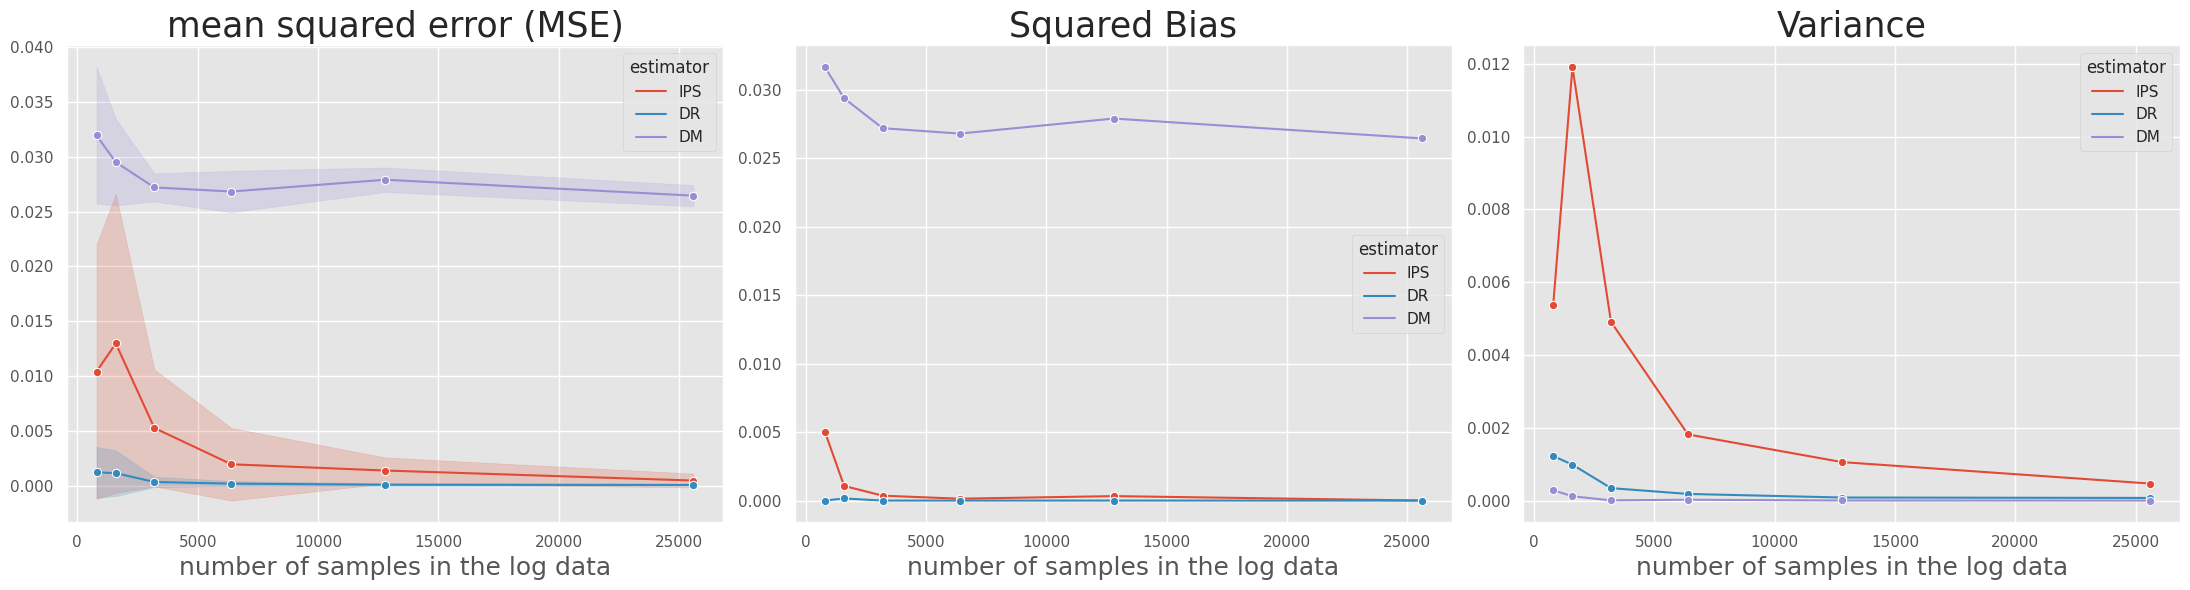

In [7]:
plt.style.use("ggplot")
fig, axes = plt.subplots(1,3, figsize=(22,6))

y=["se", "bias", "variance"]
ci=["sd", None, None]
title=["mean squared error (MSE)", "Squared Bias", "Variance"]

for ax_, y_, ci_, title_ in zip(axes, y, ci, title):
    
    sns.lineplot(data=result_df, x="n_val_data", y=y_, hue="estimator", marker="o", ci=ci_, ax=ax_)

    # title
    ax_.set_title(title_, fontsize=25)
    # yaxis
    ax_.set_ylabel('')
    # xaxis
    ax_.set_xlabel("number of samples in the log data", fontsize=18)


plt.tight_layout()
plt.show()

In [8]:
# settings 2
n_sim=5
val_size=500
test_size=100000
n_actions_list=[10,20,50,100,200,500,1000,2000]
dim_context=5

In [9]:
# experiment-2 varying number of actions

result_df_list = []
for n_actions in tqdm(n_actions_list):
    dataset = SyntheticBanditDataset(
        n_actions=n_actions,
        dim_context=dim_context,
        reward_function=logistic_reward_function,
        behavior_policy_function=linear_behavior_policy,
    )
    
    # calculate ground truth policy value
    test_data = dataset.obtain_batch_bandit_feedback(n_rounds=test_size)
    test_action_dist =  gen_eps_greedy(expected_reward=test_data["expected_reward"])
    policy_value = dataset.calc_ground_truth_policy_value(
        expected_reward=test_data["expected_reward"],
        action_dist=test_action_dist
    )
    
    result_list = []
    for _ in range(n_sim):
        val_data = dataset.obtain_batch_bandit_feedback(n_rounds=val_size)
        # pi_new
        val_action_dist = gen_eps_greedy(expected_reward=val_data["expected_reward"])

        q_hat_model = RegressionModel(
            n_actions=dataset.n_actions,
            base_model=LogisticRegression(max_iter=1000)
        )

        estimated_rewards = q_hat_model.fit_predict(
            context=val_data["context"],
            action=val_data["action"],
            reward=val_data["reward"]
        )

        ope = OffPolicyEvaluation(
            bandit_feedback=val_data,
            ope_estimators=[IPS(estimator_name="IPS"), DR(estimator_name="DR"), DM(estimator_name="DM")]
        )
        estimated_policy_values = ope.estimate_policy_values(
            action_dist=val_action_dist,
            estimated_rewards_by_reg_model=estimated_rewards
        )

        result_list.append(estimated_policy_values)
    
    result_df = (
        DataFrame(DataFrame(result_list).stack())
        .reset_index(1)
        .rename(columns={"level_1": "estimator", 0: "value"})
    )
    result_df["n_actions"] = n_actions
    result_df["se"] = (result_df["value"] - policy_value) ** 2
    result_df["bias"] = 0
    result_df["variance"] = 0
    
    expected_values = result_df.groupby('estimator').agg({"value": "mean"})["value"].to_dict()
    for estimator_name, expected_value in expected_values.items():

        row = result_df["estimator"] == estimator_name

        result_df.loc[row, "bias"] = (policy_value - expected_value) ** 2

        estimated_values = result_df[row]["value"].values
        result_df.loc[row, "variance"] = estimated_values.var()
    
    result_df_list.append(result_df)

result_df = pd.concat(result_df_list).reset_index(level=0)

100% 8/8 [01:24<00:00, 10.56s/it]


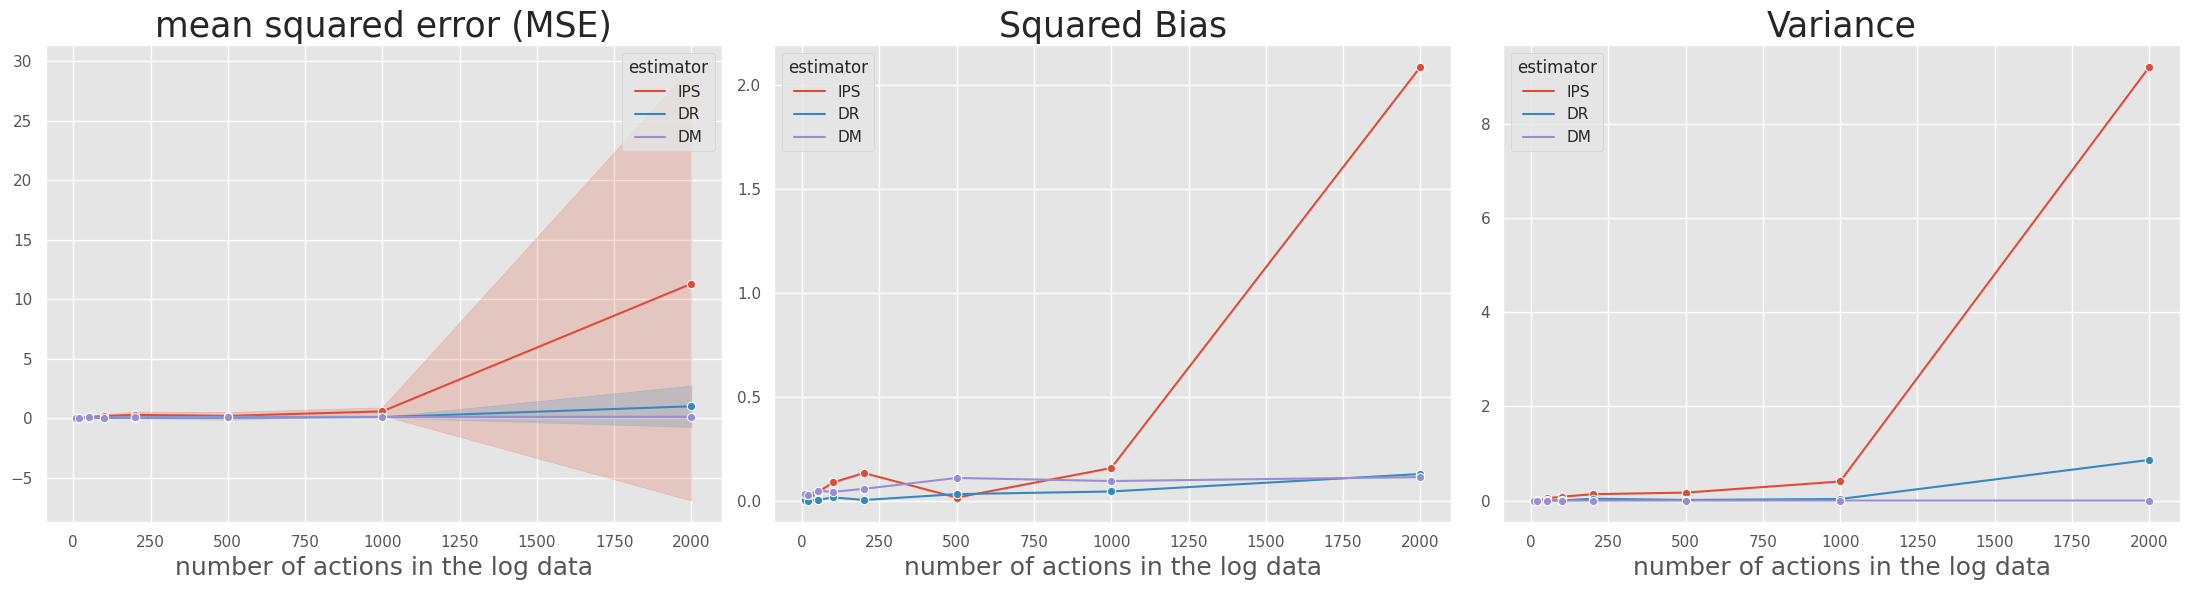

In [10]:
plt.style.use("ggplot")
fig, axes = plt.subplots(1,3, figsize=(22,6))

y=["se", "bias", "variance"]
ci=["sd", None, None]
title=["mean squared error (MSE)", "Squared Bias", "Variance"]

for ax_, y_, ci_, title_ in zip(axes, y, ci, title):
    
    sns.lineplot(data=result_df, x="n_actions", y=y_, hue="estimator", marker="o", ci=ci_, ax=ax_)

    # title
    ax_.set_title(title_, fontsize=25)
    # yaxis
    ax_.set_ylabel('')
    # xaxis
    ax_.set_xlabel("number of actions in the log data", fontsize=18)


plt.tight_layout()
plt.show()